In [289]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from IPython import display
from sklearn.model_selection import train_test_split
display.set_matplotlib_formats('svg')

<ipython-input-289-f231fd7219a8>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [290]:
iris=sns.load_dataset('iris')
data=torch.tensor(iris[iris.columns[0:4]].values).float()
label=torch.zeros(len(data),dtype=torch.long)
label[iris.species=='versicolor']=1
label[iris.species=='virginca']=2
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [291]:
data_train, data_test, label_train, label_test = train_test_split(data, label, train_size=0.8)

train_data = TensorDataset(data_train, label_train)
test_data = TensorDataset(data_test, label_test)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

In [292]:
for x,y in train_loader:
  print(x.shape,y.shape)

x,y

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


(tensor([[6.3000, 2.5000, 4.9000, 1.5000],
         [6.9000, 3.1000, 5.4000, 2.1000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [4.8000, 3.4000, 1.6000, 0.2000],
         [6.7000, 3.1000, 5.6000, 2.4000],
         [5.6000, 2.5000, 3.9000, 1.1000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [6.2000, 2.2000, 4.5000, 1.5000],
         [6.3000, 2.5000, 5.0000, 1.9000],
         [5.1000, 3.3000, 1.7000, 0.5000],
         [6.7000, 3.3000, 5.7000, 2.5000],
         [5.2000, 4.1000, 1.5000, 0.1000]]),
 tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]))

In [293]:
def create_ann_model(l2lambda):
    annclass = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    lossfunc = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(annclass.parameters(), lr=0.005, weight_decay=l2lambda)

    return annclass, lossfunc, optimizer

In [294]:
num_epochs = 1000

def train_the_model():
    train_acc = []
    test_acc = []
    losses = []

    for epoch in range(num_epochs):
        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            yhat = annclass(x)

            loss = lossfunc(yhat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100 * torch.mean((torch.argmax(yhat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

        annclass.eval()
        x, y = next(iter(test_loader))
        pred_label = torch.argmax(annclass(x), axis=1)
        test_acc.append(100 * torch.mean((pred_label == y).float()).item())
        annclass.train()

    return train_acc, test_acc, losses

In [295]:
l2_lambda = 0.01
annclass, lossfunc, optimizer = create_ann_model(l2_lambda)
train_acc, test_acc, losses = train_the_model()


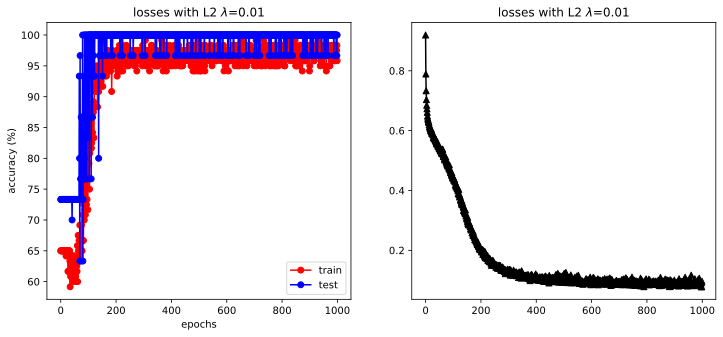

In [296]:
fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].plot(train_acc,'ro-')
ax[0].plot(test_acc,'bo-')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy (%)')
ax[0].set_title('losses with L2 $\lambda$='+str(l2_lambda))
ax[1].plot(losses,'k^-')
ax[1].set_title('losses with L2 $\lambda$='+str(l2_lambda))
ax[0].legend(['train','test'])
plt.show()